In [18]:
import os

# adding tools directory to path, so we can access the utils easily
import sys
root_path = os.path.join('.', 'tools')
sys.path.append(root_path)

import file_tools
_EXP_DIR = os.path.join('.', 'experiments')
_DATASET_DIR = os.path.join(_EXP_DIR, 'datasets')

_RESULTS_DIR = os.path.join(_EXP_DIR, 'results')
file_tools.ensure_dir(_RESULTS_DIR)

In [218]:
import dataset_tools

import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

X = dataset_tools.eeg_raw
y = [distance.euclidean(row1, row2) for row1, row2 in zip(dataset_tools.observed_faces, dataset_tools.target_faces)]
scaler = StandardScaler()
y = scaler.fit_transform(np.array(y).reshape(-1, 1)).flatten().tolist()

In [219]:
X.shape

(9234, 203)

In [67]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_components=10, n_neighbors=50, metric='euclidean', n_jobs=-1)
embedding = reducer.fit_transform(X)

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

estimator = Pipeline([
    ('scaler_x', StandardScaler()),
    ('svr', LinearRegression())
])

ss = ShuffleSplit(n_splits=10, test_size=0.1)
scorings=['neg_root_mean_squared_error']

raw_scores = cross_validate(estimator, embedding, y, cv=ss, scoring=scorings, n_jobs=-1)

In [69]:
np.mean(raw_scores['test_neg_root_mean_squared_error'])

-0.9736324422148321

Text(0.5, 1.0, 'UMAP projection of random 10-dimensional data')

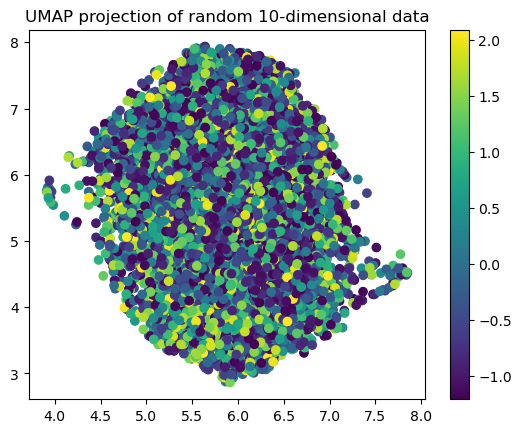

In [66]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=y)
plt.colorbar()
plt.title('UMAP projection of random 10-dimensional data')

In [201]:
indices = [3, 5, 26, 32, 34, 55, 61, 63, 84, 90, 92, 113, 119, 121, 142, 148, 150, 171, 177, 179, 200]
# indices = [26, 55, 84, 113, 142, 171, 200] # Pz
# indices = [90, 92, 113, 119, 121, 142]

# indices = [1, 3, 5, 10, 26, 28, 30, 32, 34, 39, 55, 57, 59, 61, 63, 68, 84, 86, 88, 90, 92, 97, 113, 115, 117, 119, 121, 126, 142, 144, 146, 148, 150, 155, 171, 173, 175, 177, 179, 184, 200, 202]

# indices = [1, 3, 5, 10, 21, 26, 28, 30, 32, 34, 39, 50, 55, 57, 59, 61, 63, 68, 79, 84, 86, 88, 90, 92, 97, 108, 113, 115, 117, 119, 121, 126, 137, 142, 144, 146, 148, 150, 155, 166, 171, 173, 175, 177, 179, 184, 195, 200, 202]

X2 = X[:, indices]

estimator = Pipeline([
    ('scaler_x', StandardScaler()),
    ('svr', LinearRegression())
])

ss = ShuffleSplit(n_splits=10, test_size=0.1)
scorings=['neg_root_mean_squared_error']

scores2 = cross_validate(estimator, X2, y, cv=ss, scoring=scorings, n_jobs=-1)
print(np.mean(scores2['test_neg_root_mean_squared_error']))
print(X2.shape)

-0.93695465819823
(9234, 21)


In [215]:
from sklearn.decomposition import PCA

m = []
t = []
index = [2, 5, 10, 25, 50, 100, 200]
for i in index:
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(X)

    tmp = []
    tmpt = []
    for j in range(10):
        scores3 = cross_validate(estimator, principalComponents, y, cv=ss, scoring=scorings, n_jobs=-1)
        mean_score3 = np.mean(scores3['test_neg_root_mean_squared_error'])
        tmp.append(mean_score3)
        tmpt.append(np.mean(scores3['fit_time']))
    
    m.append(np.mean(tmp))
    t.append(np.mean(tmpt))

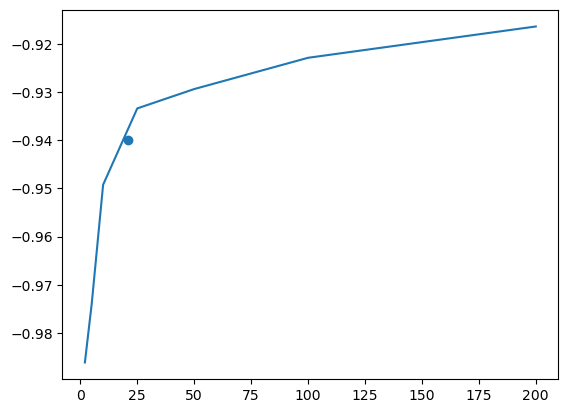

In [216]:
plt.plot(index, m)
plt.scatter(21, -0.94)

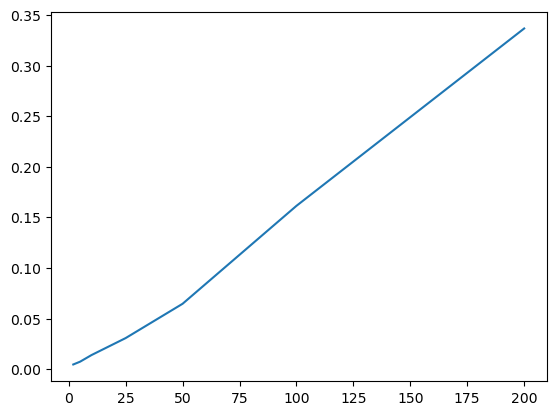

In [217]:
plt.plot(index, t)

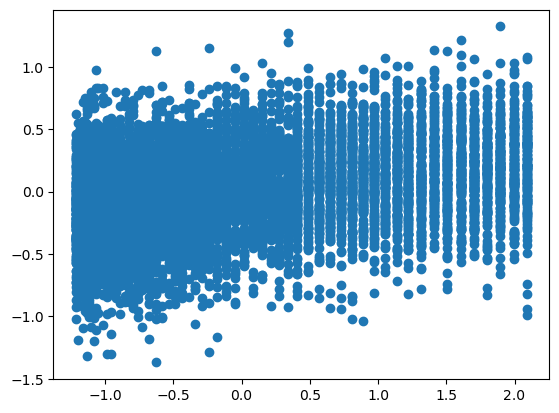

In [141]:
y_pred = estimator.fit(X2, y).predict(X2)

plt.scatter(y, y_pred)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

estimator = Pipeline([
    ('scaler_x', StandardScaler()),
    ('svr', SVR())
])

param_grid = {
    'svr__C': [0.01, 0.1],
    'svr__gamma': ['scale', 'auto'],
    'svr__kernel': ['linear', 'rbf']
}
# best svr
# {'svr__C': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}


# estimator = Pipeline([
#     ('scaler_x', StandardScaler()),
#     ('mlp', MLPRegressor(max_iter=1000))
# ])

# param_grid = {
#     'mlp__hidden_layer_sizes': [2*(100,)],
#     'mlp__activation': ['identity', 'relu'],
#     'mlp__alpha': [0.1],
#     'mlp__learning_rate': ['adaptive']
# }

# best mlp
# {'mlp__activation': 'identity',
#  'mlp__alpha': 0.1,
#  'mlp__hidden_layer_sizes': (100, 100),
#  'mlp__learning_rate': 'adaptive'}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

n_splits = 10
test_size = 0.1
ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator, 
                            param_grid,
                            cv=ss,    
                            scoring=rmse_scorer,
                            n_jobs=-1,
                            verbose=2)

grid_search.fit(X, y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.1, train_size=None),
             estimator=Pipeline(steps=[('scaler_x', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.01, 0.1], 'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['linear', 'rbf']},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=2)

In [10]:
import pandas as pd

# Convert cv_results_ to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Save to CSV
results_df.to_csv('grid_search_results.csv', index=False)

import pickle

# Save the entire GridSearchCV object
with open('grid_search_results.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

# To load:
# with open('grid_search_results.pkl', 'rb') as f:
#     loaded_grid_search = pickle.load(f)

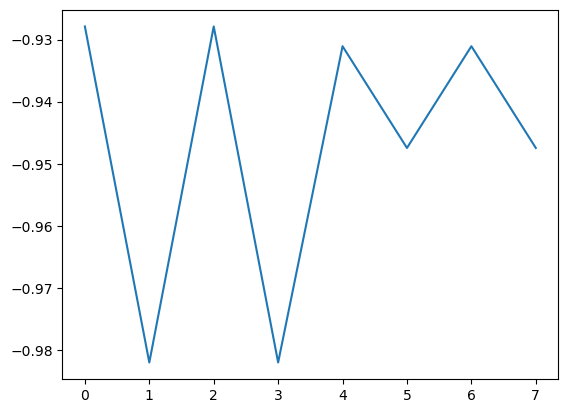

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame(grid_search.cv_results_)
plt.plot(results['mean_test_score'])
plt.show()

In [12]:
grid_search.best_params_

{'svr__C': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}

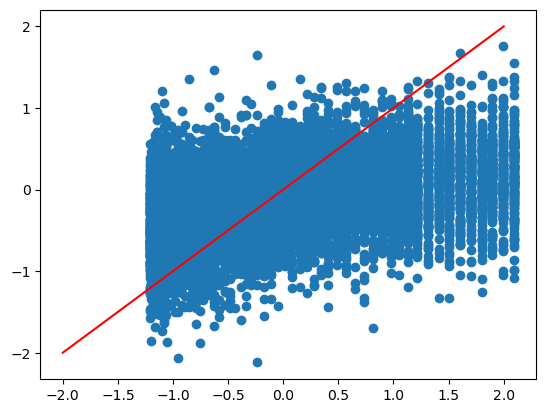

In [13]:
y_pred = grid_search.predict(X)
plt.scatter(y, y_pred)
plt.plot([-2, 2], [-2, 2], 'r')

In [14]:
grid_search.cv_results_

{'mean_fit_time': array([10.05640059,  9.91914783, 10.26371758,  9.98043389, 18.99628446,
         9.56925209, 18.81283965,  9.36978185]),
 'std_fit_time': array([0.09323066, 0.05517766, 0.09936431, 0.09356745, 0.4316478 ,
        0.07737454, 0.53696664, 0.18524327]),
 'mean_score_time': array([0.91807411, 1.76581757, 0.91159799, 1.82605138, 0.81548195,
        1.77543404, 0.77695973, 1.44622476]),
 'std_score_time': array([0.02410978, 0.02110888, 0.04851477, 0.03746784, 0.0771978 ,
        0.02389539, 0.06950674, 0.2439681 ]),
 'param_svr__C': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_svr__gamma': masked_array(data=['scale', 'scale', 'auto', 'auto', 'scale', 'scale',
                    'auto', 'auto'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object)

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.datasets import load_diabetes
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

def on_step(optim_result):
    print(f"Best score: {optim_result.fun}")

from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

estimator = Pipeline([
    ('scaler_x', StandardScaler()),
    ('svr', TransformedTargetRegressor(
        regressor=SVR(),
        transformer=StandardScaler()
    ))
])

search_spaces = {
    'svr__regressor__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'svr__regressor__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'svr__regressor__kernel': Categorical(['linear', 'rbf'])
}

opt = BayesSearchCV(
    estimator,
    search_spaces,
    scoring=rmse_scorer,
    n_iter=50,
    n_jobs=-1,
    random_state=0
)

# executes bayesian optimization
_ = opt.fit(X_train, y_train, callback=on_step)

# model can be saved, used for predictions or scoring
print(opt.score(X_test, y_test))

In [2]:
results = opt.optimizer_results_

NameError: name 'opt' is not defined

In [3]:
from skopt.plots import plot_objective
import matplotlib.pyplot as plt

# Plot for each optimization run
for i, res in enumerate(results):
    _ = plot_objective(res)
    plt.title(f"Objective Plot for Run {i+1}")
    plt.show()

NameError: name 'results' is not defined